# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here](http://nlp.stanford.edu:8080/corenlp/) to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For NLP
import nltk

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

You need to run this _once_ to download everything, you will also need [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) if you are using Windows or MacOS.

In [2]:
lucem_illud.setupStanfordNLP()

Starting downloads, this will take 5-10 minutes
../stanford-NLP/parser already exists, skipping download
../stanford-NLP/ner already exists, skipping download
../stanford-NLP/postagger already exists, skipping download
../stanford-NLP/core already exists, skipping download
[100%]Done setting up the Stanford NLP collection


We need to have stanford-NLP setup before importing, so we are doing the import here. IF you have stanford-NLP working, you can import at the beginning like you would with any other library.

In [3]:
import lucem_illud.stanford as stanford

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we have defining our own `lucem_illud` function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `stanford.openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame. You can do this through links to the Stanford Core NLP project that we provide here, or play with their interface directly (in the penultimate cell of this notebook), which produces data in "pretty graphics" like this example parsing of the first sentence in the "Shooting of Trayvon Martin" Wikipedia article:

![Output 1](../data/stanford_core1.png)
![Output 2](../data/stanford_core2.png)

First, we will illustrate these tools on some *very* short examples:

In [97]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [nltk.word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [98]:
pos_sents = stanford.postTagger.tag_sents(tokenized_text)
print(pos_sents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Trayvon', 'NNP'), ('Benjamin', 'NNP'), ('Martin', 'NNP'), ('was', 'VBD'), ('an', 'DT'), ('African', 'NNP'), ('American', 'NNP'), ('from', 'IN'), ('Miami', 'NNP'), ('Gardens', 'NNP'), (',', ','), ('Florida', 'NNP'), (',', ','), ('who', 'WP'), (',', ','), ('at', 'IN'), ('17', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('was', 'VBD'), ('fatally'

This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [99]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col=0)

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word).

In [100]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[-5:]

,author,over_18,score,subreddit,text,title,url,sentences
4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [101]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [102]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [103]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('(', 19),
 ('time', 14),
 (')', 14),
 ('lot', 12),
 ('computer', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9),
 ('**Me**', 9),
 ('system', 9),
 ('day', 9),
 ('call', 8),
 ('laptop', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7)]

What about the number of top verbs (`VB`)?

In [104]:
countTarget = 'VB'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 18),
 ('have', 17),
 ('get', 14),
 ('do', 11),
 ('change', 9),
 ('make', 8),
 ('know', 7),
 ('say', 7),
 ('help', 6),
 ('look', 6),
 ('tell', 6),
 ('send', 6),
 ('go', 5),
 ('work', 4),
 ('use', 4),
 ('receive', 4),
 ('thank', 4),
 ('feel', 4),
 ('want', 4),
 ('call', 4)]

What about the adjectives that modify the word, "computer"?

In [105]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## Evaluating POS tagger

We can check the POS tagger by running it on a manually tagged corpus and identifying a reasonable error metric.

In [106]:
treeBank = nltk.corpus.treebank
treeBank.tagged_sents()[:5]

[[('Pierre', 'NNP'),
  ('Vinken', 'NNP'),
  (',', ','),
  ('61', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  (',', ','),
  ('will', 'MD'),
  ('join', 'VB'),
  ('the', 'DT'),
  ('board', 'NN'),
  ('as', 'IN'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('Nov.', 'NNP'),
  ('29', 'CD'),
  ('.', '.')],
 [('Mr.', 'NNP'),
  ('Vinken', 'NNP'),
  ('is', 'VBZ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Elsevier', 'NNP'),
  ('N.V.', 'NNP'),
  (',', ','),
  ('the', 'DT'),
  ('Dutch', 'NNP'),
  ('publishing', 'VBG'),
  ('group', 'NN'),
  ('.', '.')],
 [('Rudolph', 'NNP'),
  ('Agnew', 'NNP'),
  (',', ','),
  ('55', 'CD'),
  ('years', 'NNS'),
  ('old', 'JJ'),
  ('and', 'CC'),
  ('former', 'JJ'),
  ('chairman', 'NN'),
  ('of', 'IN'),
  ('Consolidated', 'NNP'),
  ('Gold', 'NNP'),
  ('Fields', 'NNP'),
  ('PLC', 'NNP'),
  (',', ','),
  ('was', 'VBD'),
  ('named', 'VBN'),
  ('*-1', '-NONE-'),
  ('a', 'DT'),
  ('nonexecutive', 'JJ'),
  ('director', 'NN'),
  ('of', 'IN'),
  ('this'

In [107]:
treeBank.sents()[0]

['Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.']

In [108]:
stanfordTags = stanford.postTagger.tag_sents(treeBank.sents()[:30])

And compare the two

In [109]:
NumDiffs = 0
for sentIndex in range(len(stanfordTags)):
    for wordIndex in range(len(stanfordTags[sentIndex])):
        if stanfordTags[sentIndex][wordIndex][1] != treeBank.tagged_sents()[sentIndex][wordIndex][1]:
            if treeBank.tagged_sents()[sentIndex][wordIndex][1] != '-NONE-':
                print("Word: {}  \tStanford: {}\tTreebank: {}".format(stanfordTags[sentIndex][wordIndex][0], stanfordTags[sentIndex][wordIndex][1], treeBank.tagged_sents()[sentIndex][wordIndex][1]))
                NumDiffs += 1
total = sum([len(s) for s in stanfordTags])
print("The Precision is {:.3f}%".format((total-NumDiffs)/total * 100))

Word: Dutch  	Stanford: JJ	Treebank: NNP
Word: publishing  	Stanford: NN	Treebank: VBG
Word: used  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: that  	Stanford: IN	Treebank: WDT
Word: later  	Stanford: RB	Treebank: JJ
Word: New  	Stanford: NNP	Treebank: JJ
Word: that  	Stanford: IN	Treebank: WDT
Word: more  	Stanford: JJR	Treebank: RBR
Word: ago  	Stanford: RB	Treebank: IN
Word: ago  	Stanford: RB	Treebank: IN
Word: replaced  	Stanford: VBD	Treebank: VBN
Word: more  	Stanford: JJR	Treebank: JJ
Word: expected  	Stanford: VBD	Treebank: VBN
Word: study  	Stanford: VBD	Treebank: VBP
Word: studied  	Stanford: VBD	Treebank: VBN
Word: industrialized  	Stanford: JJ	Treebank: VBN
Word: Lorillard  	Stanford: NNP	Treebank: NN
Word: found  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT
Word: that  	Stanford: IN	Treebank: WDT
Word: rejected  	Stanford: VBD	Treebank: VBN
Word: that  	Stanford: IN	Treebank: WDT

So we can see that the stanford POS tagger is quite good. Nevertheless, for a 20 word sentence, we only have a 66% chance ($1-.96^{20}$) of tagging (and later parsing) it correctly.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional frequencies (e.g., adjectives associated with nouns of interest or adverbs with verbs of interest). What do these distributions suggest about your corpus?

It is interesting seeing how Microsoft classifies their business and likely could provide information when comparing across time.

In [110]:
#original data
letters = pandas.read_pickle('/home/szmurlo/Downloads/pandasDF.pkl')
letters['a'] = 0
letters.head(20)
for index, row in letters.iterrows():

    if 'Microsoft' in row['company']:
        letters.loc[index,'a'] = 1

#microsoft letters
microsoft =letters.loc[letters['a']==1]
#removing bad data
microsoft= microsoft[microsoft.index!=21]
microsoft=microsoft[microsoft.index!=230]
microsoft


,company,text,year,a
27,Microsoft,"To our shareholders, customers, partners, and ...",2005,1
35,Microsoft,"To our shareholders, customers, partners, and ...",2006,1
46,Microsoft,"To our shareholders, customers, partners and e...",2007,1
61,Microsoft,"To our shareholders, customers, partners, and ...",2008,1
77,Microsoft,"To our shareholders, customers, partners, and ...",2009,1
127,Microsoft,"TO OUR SHAREHOLDERS, CUSTOMERS, PARTNERS, AND ...",2011,1
151,Microsoft,"TO OUR SHAREHOLDERS, CUSTOMERS, PARTNERS AND E...",2012,1
176,Microsoft,"TO OUR SHAREHOLDERS, CUSTOM ERS, PARTNERS AND ...",2013,1
203,Microsoft,"TO OUR SHAREHOLDERS, CUSTOMERS, PARTNERS AND E...",2014,1
255,Microsoft,"Dear shareholders, customers, partners, and em...",2016,1


In [111]:
microsoft['sentences'] = microsoft['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
microsoft.index = range(len(microsoft) - 1, -1,-1) #Reindex to make things nice in the future
microsoft[-5:]

,company,text,year,a,sentences
4,Microsoft,"TO OUR SHAREHOLDERS, CUSTOMERS, PARTNERS AND E...",2012,1,"[[TO, OUR, SHAREHOLDERS, ,, CUSTOMERS, ,, PART..."
3,Microsoft,"TO OUR SHAREHOLDERS, CUSTOM ERS, PARTNERS AND ...",2013,1,"[[TO, OUR, SHAREHOLDERS, ,, CUSTOM, ERS, ,, PA..."
2,Microsoft,"TO OUR SHAREHOLDERS, CUSTOMERS, PARTNERS AND E...",2014,1,"[[TO, OUR, SHAREHOLDERS, ,, CUSTOMERS, ,, PART..."
1,Microsoft,"Dear shareholders, customers, partners, and em...",2016,1,"[[Dear, shareholders, ,, customers, ,, partner..."
0,Microsoft,"Dear shareholders, customers, partners and emp...",2017,1,"[[Dear, shareholders, ,, customers, ,, partner..."


In [112]:
microsoft['POS_sents'] = microsoft['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [113]:
#nouns
countTarget = 'NN'
targetCounts = {}
for entry in microsoft['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('year', 95),
 ('business', 82),
 ('technology', 81),
 ('growth', 69),
 ('software', 66),
 ('cloud', 61),
 ('world', 58),
 ('percent', 57),
 ('company', 53),
 ('revenue', 52),
 ('â\x80\x94', 43),
 ('opportunity', 38),
 ('computing', 38),
 ('Server', 37),
 ('work', 32),
 ('information', 30),
 ('search', 29),
 ('development', 28),
 ('way', 28),
 ('innovation', 28)]

In [114]:
#verbs
countTarget = 'VB'
targetCounts = {}
for entry in microsoft['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 46),
 ('help', 36),
 ('deliver', 22),
 ('drive', 21),
 ('enable', 20),
 ('create', 19),
 ('continue', 18),
 ('make', 18),
 ('build', 18),
 ('achieve', 15),
 ('grow', 13),
 ('Search', 12),
 ('bring', 12),
 ('use', 10),
 ('transform', 10),
 ('empower', 10),
 ('provide', 9),
 ('change', 9),
 ('Thank', 9),
 ('have', 9)]

In [115]:
#adjectives
#verbs
countTarget = 'JJ'
targetCounts = {}
for entry in microsoft['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('new', 183),
 ('fiscal', 57),
 ('important', 42),
 ('digital', 33),
 ('strong', 31),
 ('past', 29),
 ('mobile', 28),
 ('such', 26),
 ('many', 23),
 ('economic', 23),
 ('other', 22),
 ('global', 19),
 ('next', 18),
 ('key', 17),
 ('great', 17),
 ('significant', 15),
 ('future', 13),
 ('innovative', 13),
 ('incredible', 13),
 ('natural', 13)]

In [116]:
#adjectives that modify business
NTarget = 'JJ'
Word = 'business'
NResults = set()
for entry in microsoft['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)  

{'massive', 'small', 'major', 'difficult', 'Essential', 'hardware-centric', 'disruptive', 'large', 'modular', 'new', 'Internet-based'}


# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

First, we tag our first set of exemplary sentences:

In [117]:
classified_sents = stanford.nerTagger.tag_sents(tokenized_text)
print(classified_sents)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Trayvon', 'PERSON'), ('Benjamin', 'PERSON'), ('Martin', 'PERSON'), ('was', 'O'), ('an', 'O'), ('African', 'O'), ('American', 'O'), ('from', 'O'), ('Miami', 'LOCATION'), ('Gardens', 'LOCATION'), (',', 'O'), ('Florida', 'LOCATION'), (',', 'O'), ('who', 'O'), (',', 'O'), ('at', 'O'), ('17', 'O'), ('years', 'O'), ('old', 'O'), (',', 'O'), ('was', 'O'), 

We can also run NER over our entire corpus:

In [118]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))

In [119]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [120]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or those occurring only twice:

In [121]:
[x[0] for x in sortedEntities if x[1] == 2]

['year',
 'Desk',
 'busy',
 'fix',
 'received',
 'couple',
 'Windows',
 'anymore',
 'Sure',
 'error',
 'DVD',
 'opened',
 'There',
 'upside',
 'local',
 'bane',
 'existence',
 'learn',
 'sometimes',
 'generic',
 'Everyone',
 'login',
 'times',
 'guy',
 'asset',
 'name',
 'Computer',
 'nothing',
 "'P4ssword",
 'P',
 'Everything',
 'case',
 '*type',
 'S',
 'LOWERCASE',
 'used',
 'four',
 'Original',
 'cancer',
 'month',
 'live',
 'brave',
 'bitter',
 'passed',
 'ago',
 'absolutely',
 'ready',
 'proud',
 'above',
 'completely',
 'its',
 'meant',
 'both',
 'sharing',
 'making',
 '100',
 'share',
 'looking',
 'ALL',
 'whom',
 'business',
 'whose',
 'stronger',
 'bad',
 'mess',
 'turn',
 'first',
 'others',
 'Here',
 'suggested',
 'videos',
 'While',
 'stand',
 'certain',
 'enjoy',
 'well',
 'drowned',
 'soon',
 'understand',
 'risks',
 'myself',
 'point',
 'future',
 'avoid',
 'thinking',
 'information',
 'insurance',
 'site',
 'step',
 'guide',
 'discover',
 'order',
 '5',
 'slightly',
 's

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [122]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('Citrix', 1),
 ('Nono', 1),
 ('Reddit', 1),
 ('Helpdesk', 1),
 ('UK', 1),
 ('CMD', 1)]

What about the Organizations?

In [123]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Google', 6), ('Citrix', 1), ('Helpdesk', 1), ('CMD', 1), ('GOOGLE', 1)]

These, of course, have much smaller counts.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed (using your own hand-codings as "ground truth").

In [124]:
microsoft['classified_sents'] = microsoft['sentences'].apply(lambda x: stanford.nerTagger.tag_sents(x))
microsoft.head()

,company,text,year,a,sentences,POS_sents,classified_sents
10,Microsoft,"To our shareholders, customers, partners, and ...",2005,1,"[[To, our, shareholders, ,, customers, ,, part...","[[(To, TO), (our, PRP$), (shareholders, NNS), ...","[[(To, O), (our, O), (shareholders, O), (,, O)..."
9,Microsoft,"To our shareholders, customers, partners, and ...",2006,1,"[[To, our, shareholders, ,, customers, ,, part...","[[(To, TO), (our, PRP$), (shareholders, NNS), ...","[[(To, O), (our, O), (shareholders, O), (,, O)..."
8,Microsoft,"To our shareholders, customers, partners and e...",2007,1,"[[To, our, shareholders, ,, customers, ,, part...","[[(To, TO), (our, PRP$), (shareholders, NNS), ...","[[(To, O), (our, O), (shareholders, O), (,, O)..."
7,Microsoft,"To our shareholders, customers, partners, and ...",2008,1,"[[To, our, shareholders, ,, customers, ,, part...","[[(To, TO), (our, PRP$), (shareholders, NNS), ...","[[(To, O), (our, O), (shareholders, O), (,, O)..."
6,Microsoft,"To our shareholders, customers, partners, and ...",2009,1,"[[To, our, shareholders, ,, customers, ,, part...","[[(To, TO), (our, PRP$), (shareholders, NNS), ...","[[(To, O), (our, O), (shareholders, O), (,, O)..."


In [125]:
#most common entities
entityCounts = {}
for entry in microsoft['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[(',', 1209),
 ('and', 1025),
 ('.', 824),
 ('the', 734),
 ('to', 634),
 ('of', 496),
 ('in', 412),
 ('our', 338),
 ('we', 306),
 ('a', 296)]

In [126]:
#most common non-objects
nonObjCounts = {}
for entry in microsoft['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Microsoft', 184),
 ('Dynamics', 15),
 ('Office', 13),
 ('Bing', 11),
 ('Skype', 9),
 ('Steven', 8),
 ('A.', 8),
 ('Ballmer', 8),
 ('Research', 7),
 ('Cortana', 7)]

In [127]:
#most common organizations
OrgCounts = {}
for entry in microsoft['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Microsoft', 184),
 ('Dynamics', 15),
 ('Office', 13),
 ('Skype', 9),
 ('Research', 7),
 ('&', 6),
 ('Communications', 5),
 ('Services', 5),
 ('Devices', 5),
 ('Nokia', 5)]

In [128]:
microsoft2012 = microsoft[microsoft.index==4]
microsoft2012
OrgCounts = {}
a = []
for entry in microsoft2012['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                if 'Dynamics' in ent:
                    a.append(sentence)
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
for each in a:
    print(each)
sortedOrgs[:10]

[('Microsoft', 12), ('Dynamics', 2), ('Skype', 1)]

In [129]:
count = 0
for index, row in microsoft2012.iterrows():
    for each in row['sentences']:
        if 'Microsoft' in each:
            count +=1
            print(each)
print(count)

['TO', 'OUR', 'SHAREHOLDERS', ',', 'CUSTOMERS', ',', 'PARTNERS', 'AND', 'EMPLOYEES', ':', 'Last', 'year', 'was', 'a', 'big', 'year', 'â\x80\x94', 'we', 'delivered', 'strong', 'results', ',', 'launched', 'fantastic', 'new', 'products', 'and', 'services', ',', 'and', 'positioned', 'Microsoft', 'for', 'an', 'incredible', 'future', '.']
['There', 'will', 'be', 'times', 'when', 'we', 'build', 'speciï¬\x81c', 'devices', 'for', 'speciï¬\x81c', 'purposes', ',', 'as', 'we', 'have', 'chosen', 'to', 'do', 'with', 'Xbox', 'and', 'the', 'recently', 'announced', 'Microsoft', 'Surface', '.']
['So', 'right', 'out', 'of', 'the', 'box', ',', 'a', 'customer', 'will', 'get', 'a', 'stunning', 'device', 'that', 'is', 'connected', 'to', 'unique', 'communications', ',', 'productivity', 'and', 'entertainment', 'services', 'from', 'Microsoft', 'as', 'well', 'as', 'access', 'to', 'great', 'services', 'and', 'applications', 'from', 'our', 'partners', 'and', 'developers', 'around', 'the', 'world', '.']
['Itâ\x80\x

In the Microsoft 2012 Annual Letter to Shareholders the word 'Microsoft' was used 12 times. 9 times as the organziation and 3 times describing other objects (i.e. Microsoft Surface & Microsoft Dynamics). The NER classification algorithm classified the word all 12 times as an organization.

Precision: .75
Recall: 1.0
F-Score: 0.43

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [130]:
parses = list(stanford.parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fourthSentParseTree = list(parses[3]) #iterators so be careful about re-running code, without re-running this block
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Trayvon']), Tree('NNP', ['Benjamin']), Tree('NNP', ['Martin'])]), Tree('VP', [Tree('VBD', ['was']), Tree('NP', [Tree('NP', [Tree('DT', ['an']), Tree('NNP', ['African']), Tree('NNP', ['American'])]), Tree('PP', [Tree('IN', ['from']), Tree('NP', [Tree('NP', [Tree('NNP', ['Miami']), Tree('NNPS', ['Gardens'])]), Tree(',', [',']), Tree('NP', [Tree('NNP', ['Florida'])]), Tree(',', [',']), Tree('SBAR', [Tree('WHNP', [Tree('WP', ['who'])]), Tree('S', [Tree(',', [',']), Tree('PP', [Tree('IN', ['at']), Tree('ADJP', [Tree('NP', [Tree('CD', ['17']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])])]), Tree(',', [',']), Tree('VP', [Tree('VBD', ['was']), Tree('ADVP', [Tree('RB', ['fatally'])]), Tree('VP', [Tree('VBN', ['shot']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('NP', [Tree('NNP', ['George']), Tree('NNP', ['Zimmerman'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['neighborhood']), Tree('NN', ['watch']), Tree('NN', [

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [131]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [132]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [133]:
treeRelation(fourthSentParseTree, 'NP', 'Florida', 'who')

[[('NP',
   'an African American from Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')],
 [('NP',
   'Miami Gardens , Florida , who , at 17 years old , was fatally shot by George Zimmerman , a neighborhood watch volunteer , in Sanford , Florida')]]

Notice that Florida occurs twice in two different nested noun phrases in the sentence. 

We can also find all of the verbs within the noun phrase defined by one or more target words:

In [134]:
treeSubRelation(fourthSentParseTree, 'NP', 'VBN', 'Florida', 'who')

{'shot'}

Or if we want to to look at the whole tree

In [135]:
fourthSentParseTree[0].pretty_print()

                                                                                                                   ROOT                                                                                                                       
                                                                                                                    |                                                                                                                          
                                                                                                                    S                                                                                                                         
            ________________________________________________________________________________________________________|_______________________________________________________________________________________________________________________   
           |                       VP     

Or another sentence

In [136]:
list(parses[1])[0].pretty_print()

                     ROOT                           
                      |                              
                      S                             
       _______________|___________________________   
      |                          VP               | 
      |                __________|___             |  
      |               |              PP           | 
      |               |      ________|___         |  
      NP              |     |            NP       | 
  ____|__________     |     |     _______|____    |  
 DT   JJ    JJ   NN  VBD    IN   DT      JJ   NN  . 
 |    |     |    |    |     |    |       |    |   |  
The quick brown fox jumped over the     lazy dog  . 



## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [137]:
depParses = list(stanford.depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x7f3b425a4268>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'w

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another. We note that unless you have the graphviz successfully installed on your computer (which is not necessary to complete this homework), the following graphviz call will trigger an error. If you are interested in installing graphviz and working on a Mac, consider installing through [homebrew](https://brew.sh), a package manager (i.e., with the command "brew install graphviz", once brew is installed). 

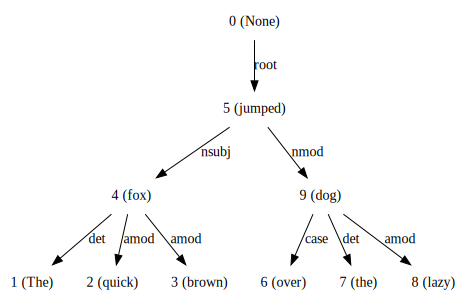

In [138]:
try:
    secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
except:
    secondSentGraph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
secondSentGraph

Or another sentence 

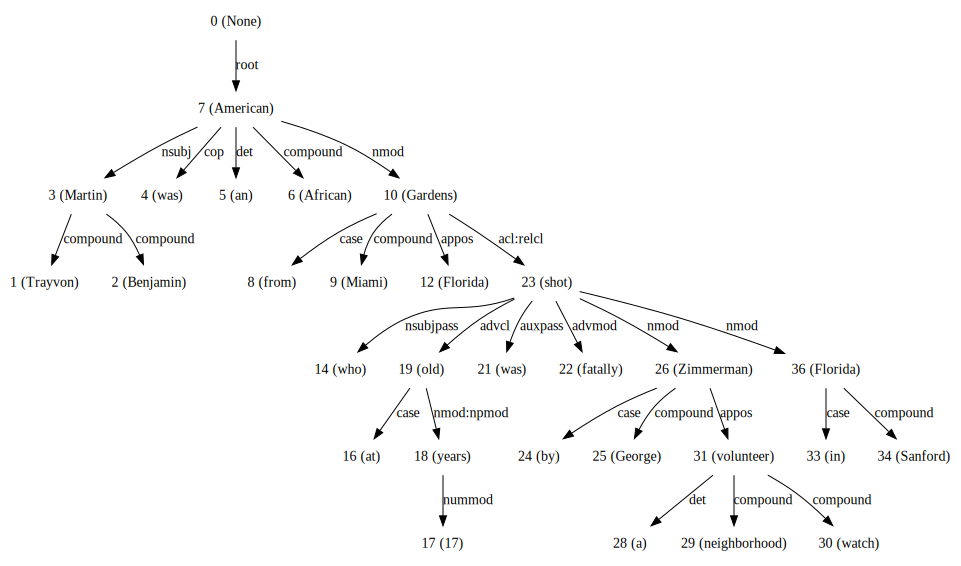

In [139]:
try:
    graph = graphviz.Source(list(depParses[3])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph

We can also do a dependency parse on the reddit sentences:

In [140]:
topPostDepParse = list(stanford.depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree from one of the processed sentences.

The sentence is:

In [141]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree:

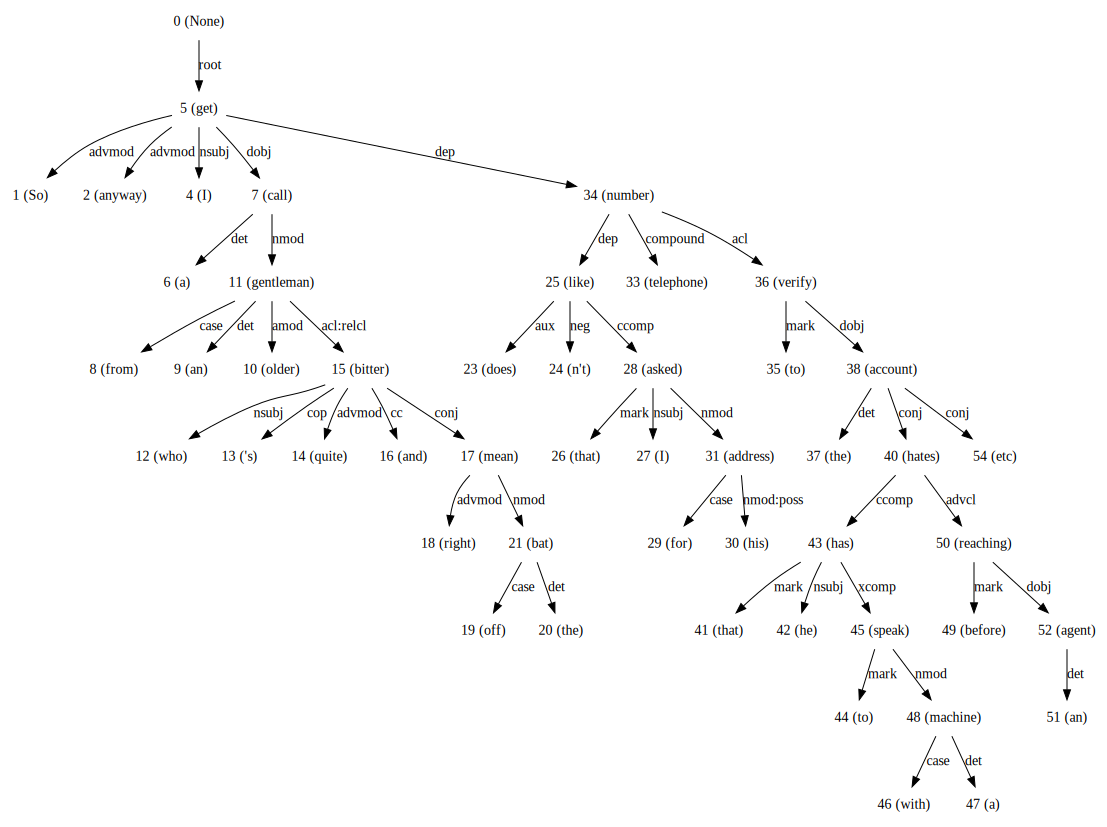

In [142]:
try:
    graph = graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceived to play in the social world inscribed by your texts?

In [143]:
micro12letter = list(stanford.depParser.parse_sents(microsoft2012['sentences'].sum()))

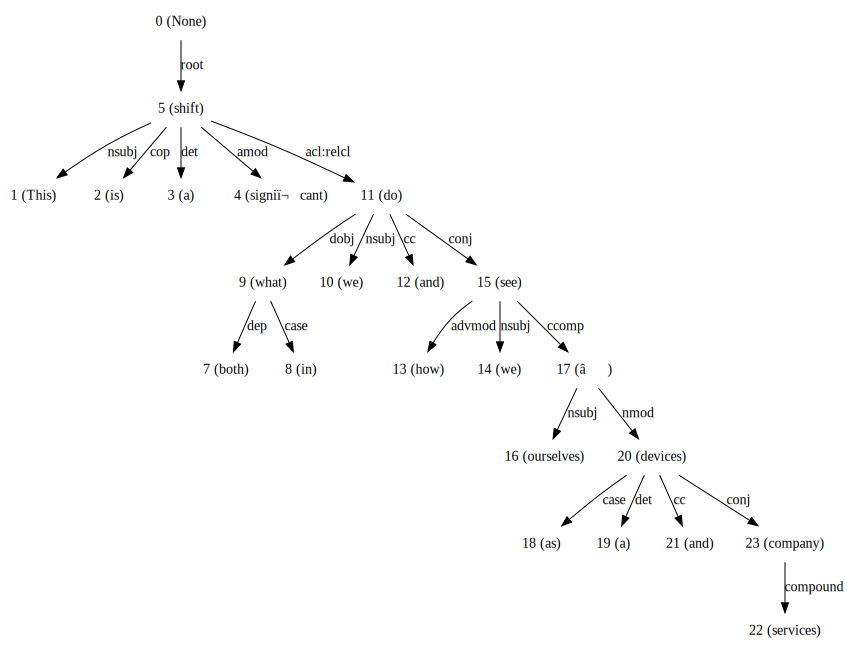

In [144]:
try:
    graph = graphviz.Source(list(micro12letter[targetSentence])[0].to_dot())
except IndexError:
    print("You likely have to rerun the depParses")
    raise
except:
    graph = None
    print("There was a problem with graphviz, likely your missing the program, https://www.graphviz.org/download/")
graph


The above graph is interesting  because while the upper echelon of the graph is not telling, the bottom right can describe microsoft as a 'device' company that provides mostly 'services'

In [145]:
parsed = list(stanford.parser.parse_sents(microsoft2012.sentences.sum())) 
sentMicroParseTree = list(parsed[3]) 
print(sentMicroParseTree)

[Tree('ROOT', [Tree('S', [Tree('PP', [Tree('IN', ['In']), Tree('NP', [Tree('NN', ['addition'])])]), Tree(',', [',']), Tree('NP', [Tree('PRP', ['we'])]), Tree('VP', [Tree('VBD', ['returned']), Tree('NP', [Tree('QP', [Tree('$', ['$']), Tree('CD', ['10.7']), Tree('CD', ['billion'])])]), Tree('PP', [Tree('TO', ['to']), Tree('NP', [Tree('NNS', ['shareholders'])])]), Tree('PP', [Tree('IN', ['through']), Tree('NP', [Tree('NN', ['stock']), Tree('NNS', ['buybacks']), Tree('CC', ['and']), Tree('NNS', ['dividends'])])])]), Tree('.', ['.'])])])]


In [146]:
treeRelation(sentMicroParseTree, 'NP', 'stock','dividends')

[[('NP', 'stock buybacks and dividends')]]

In [147]:
sentMicroParseTree[0].pretty_print()

                                             ROOT                                                               
                                              |                                                                  
                                              S                                                                 
      ________________________________________|_______________________________________________________________   
     |            |   |                                         VP                                            | 
     |            |   |      ___________________________________|_________________                            |  
     PP           |   |     |          NP               PP                        PP                          | 
  ___|_____       |   |     |          |             ___|_______            ______|______                     |  
 |         NP     |   NP    |          QP           |           NP         |             NP 

The parsed sentences describe that Microsoft is a services/device platform company that returns money to shareholders.

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

In [150]:

ieDF = stanford.openIE(text)

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.8 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 12.434 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [14.4 sec].
[main] INFO edu.stanford.nlp.pip

`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take at least 12 seconds.

In [151]:
ieDF

,certainty,subject,verb,object


No buffalos (because there were no verbs), but the rest is somewhat promising. Note, however, that it abandoned the key theme of the sentence about the tragic Trayvon Martin death ("fatally shot"), likely because it was buried so deeply within the complex phrase structure. This is obviously a challenge. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">How would you extract relevant information about the Trayvon Martin sentence directly from the dependency parse (above)? Code an example here. (For instance, what compound nouns show up with what verb phrases within the sentence?) How could these approaches inform your research project?

In [ ]:
sentence = 'Trayvon Benjamin Martin was an African American from Miami Gardens, Florida, who, at 17 years old, was fatally shot by George Zimmerman, a neighborhood watch volunteer, in Sanford, Florida.'

In [5]:
#having trouble with the stanford.openIE(), copying sentence to the stanford server
stanford.startCoreServer()

Starting server on http://10.50.221.87:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop           (((っ･д･)っ             
Exiting (ノ≧▽≦)ノ


Note: on the RCC server, I have access to firefox, which is not compatible with the stanford server linked above. Therefore, on my home computer, I typed the above sentence into the Stanford Parser found at https://nlp.stanford.edu/software/lex-parser.shtml in the 'online' link.

I find the compound nouns 'George Zimmerman' and shot are linked, but not 'Trayvon Martin' and shot. However, 'was' and 'shot' are linked, as well as, 'who' and 'shot.' Adjectives are better linked to the nouns. This infers that descriptions of actors are likely more accurate than their actions, if only because there was no clear identification of who got shot and who was shooting.

And we can also look for subject, object, target triples in one of the reddit stories.

In [91]:
ieDF = stanford.openIE(redditTopScores['text'][0])

Starting OpenIE run
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator depparse
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
[main] INFO edu.stanford.nlp.parser.nndep.Classifier - PreComputed 99996, Elapsed Time: 8.811 (s)
[main] INFO edu.stanford.nlp.parser.nndep.DependencyParser - Initializing dependency parser ... done [10.6 sec].
[main] INFO edu.stanford.nlp.pipe

In [92]:
ieDF

,certainty,subject,verb,object


That's almost 200 triples in only:

In [152]:
len(redditTopScores['sentences'][0])

37

sentences and

In [153]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject in this story.

In [154]:
ieDF['subject'].value_counts()

Series([], Name: subject, dtype: int64)

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [155]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

Series([], Name: verb, dtype: int64)

and the following objects

In [156]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Series([], Name: object, dtype: int64)

We can also run the corenlp server. When you run this server (with the command below), you can click on the browswer link provided to experiment with it. Note that when we run the server, executing the command below, it interrupts the current jupyter process and you will not be able to run code here again (processes will "hang" and never finish) until you interrup the process by clicking "Kernel" and then "Interrupt".

In [157]:
stanford.startCoreServer()

Starting server on http://10.50.222.119:16432 , please wait a few seconds
click Kernel -> Then Interupt to stop   (((っ･д･)っ                     
Exiting (ノ≧▽≦)ノ


Note: the stanford server is not compatible on firefox, which is the only web browser I have available on RCC. Therefore, I typed the sentence into the Stanford parser provided at the 'online' link at this page: https://nlp.stanford.edu/software/lex-parser.shtml

I found compound noun 'George Zimmerman' linked with verb 'shot' however not 'Trayvon Martin.' I found 'who' and 'shot' linked, also 'was' and 'shot' were linked. Meanwhile, the adjectives were clearly linked with the compound nouns. Therefore, I infer that descriptors of actors may be easier for the algorithm to uncover than their actual actions.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa. Describe how you would select among these statements to create a database of high-value statements for your project and then do it by extracting relevant statements into a pandas dataframe.